## Data Exploration/Analysis

Ultimate goal is to predict median sale price per square foot of a house in the neighborhood.

Current step: EDA

Next step: PCA and Clustering. See what patterns emerge in the clusters.

Final step: predict median sale price.

Important to remember: we only want to predict *home values*, not all real estate values. 

In [125]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
%matplotlib inline
sns.set(style='darkgrid')

In [126]:
df= pd.read_csv('merged.csv')

In [127]:
def integizer(string):
    for i in string:
        if i == '':
            return None
        else:
            return int(i)

def dolcomma(col):
    return pd.to_numeric(col.map(lambda x: x.replace(',', '').replace('$','')), downcast='integer')

def floatizer(string):
    for i in string:
        if i == '':
            return None
        else:
            continue
    return float(string)

In [128]:
#Cleaning up monetary columns and converting to integer
df['Assessment Improvement Improved']=dolcomma(df['Assessment Land'])
df['Most Recent Sale Price Improved'] =dolcomma(df['Most Recent Sale Price'])
df['Square Footage Improved'] = dolcomma(df['Square Footage'])
df['Improvement Value Improved']= dolcomma(df['Improvement Value'])
df['Assessment Total Improved']= dolcomma(df['Assessment Total'])
df['Land Value Improved']=dolcomma(df['Land Value'])
df['Assessment Land Improved']=dolcomma(df['Assessment Land'])
df['Total Appraisal Value Improved']=dolcomma(df['Total Appraisal Value'])

In [129]:
#Cleaning up certain date columns
df['Most Recent Sale Date']=pd.to_datetime(df['Most Recent Sale Date'])
df['Sale Date']=pd.to_datetime(df['Sale Date'])

In [130]:
#Converting 'Land Area' column to clean float
df['Land Area Acres'] = df['Land Area'].map(lambda x: x.replace(' ','').replace('Acres', '')).map(lambda x: float(x))

In [131]:
df['Land Value Improved'].head(10)
#I noticed adjacent parcels will often all have the same appraised land value.

0    80000.0
1    80000.0
2    80000.0
3    80000.0
4    83200.0
5    65000.0
6      800.0
7    65000.0
8    65000.0
9    65000.0
Name: Land Value Improved, dtype: float64

In [132]:
#Neighborhood column is all numbers, but it's categorical.
df.Neighborhood = df.Neighborhood.map(lambda x: str(x))

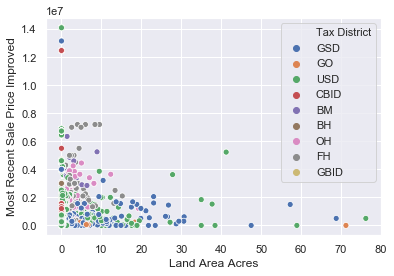

In [11]:
sns.scatterplot(y=df['Most Recent Sale Price Improved'],x=df['Land Area Acres'], hue = df['Tax District'])

In [133]:
#Many neighborhoods only have 1 or 2 observations. We need to delete neighborhoods with 3 or less observations.
df['Neighborhood'].value_counts()
#.gt() = 'greater than'
s=df.Neighborhood.value_counts().gt(3)
df.loc[df.Neighborhood.isin(s[s].index)].shape
#Removes 124 observations from original dataframe.

(71696, 54)

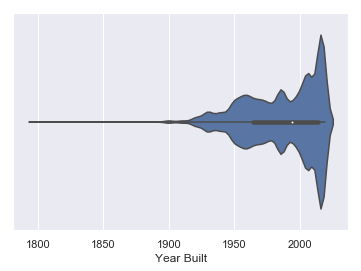

In [13]:
sns.violinplot(df['Year Built'])

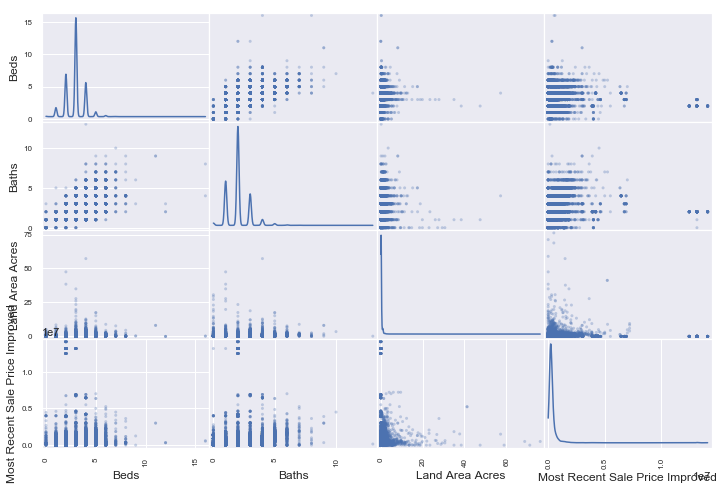

In [203]:
pd.plotting.scatter_matrix(df[['Beds','Baths', 'Land Area Acres','Most Recent Sale Price Improved']], alpha = 0.3,figsize = (12,8), diagonal = 'kde');

In [162]:
#Need to convert this to numeric. Split-level = 1.5, 1.75 story= 1.5
df['Story Height Improved'] = df['Story Height'].astype(str).map(lambda x: x.replace('STY', '').replace('STORY','').replace(' ', '').replace('TWO', '2').replace('ONE', '1'))
df['Story Height Improved']=df['Story Height Improved'].map(lambda x: x.replace('THREE', '3').replace('SPLIT-LEVEL','1.5').replace('BI-LEVEL', '2')).replace('1.75','1.5')
df['Story Height Improved']=df['Story Height Improved'].map(lambda x: float(x))

In [51]:
len(df['Neighborhood'].unique())
#This will be getting pretty granular

830

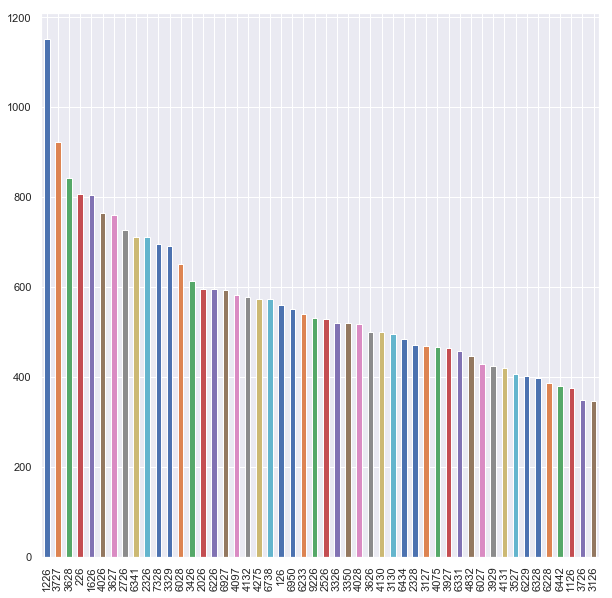

In [58]:
plt.figure(figsize=(10,10))
df.Neighborhood.value_counts()[:50].plot('bar')
plt.show()
#Nice even class distribution

In [135]:
#I'm going to clean up the classifications here, combine similar values
#Rural = Ag/Res = Res/Ag = Res/Forest = Farm/Agr = FRM
df['Assessment Classification'] = df['Assessment Classification'].replace('FOREST/RES', 'RURAL').replace('RES/AGR', 'RURAL').replace('FARM/AGR', 'RURAL').replace('FRST/FRM', 'RURAL')
df['Assessment Classification'] = df['Assessment Classification'].replace('AG/RES', 'RURAL').replace('RES/FOREST', 'RURAL').replace('FRM','RURAL')
df['Assessment Classification']= df['Assessment Classification'].replace('')
print(df['Assessment Classification'].value_counts())

RES        69245
COM         2435
EXE           46
RURAL         38
RES/COM       16
CA/OS         15
COM/RES       12
AO             9
EXE/COM        1
GOV            1
OSAP           1
EXE VAC        1
Name: Assessment Classification, dtype: int64


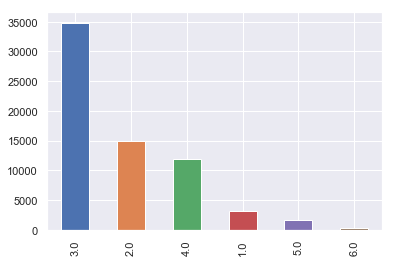

In [122]:
df.Beds.value_counts()[:6].plot('bar')

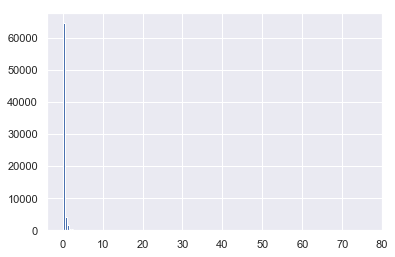

In [20]:
df['Land Area Acres'].hist(bins=150)
#We have some outliers, consider removing
#Important observation: the vsat majority of these units are multifamily (land area of 0)

In [138]:
#Add 0.5 to Baths for each "half bath" listed?
#Or not. This is a potential indicator of PPSF
df['Half Bath'].value_counts()

0.0    38723
1.0    27447
2.0     1031
3.0       56
4.0       10
5.0        3
Name: Half Bath, dtype: int64

In [19]:
df['Building Condition'].value_counts()

Average        65906
Fair             761
Good             271
Poor             119
Very Good         49
Very Poor         34
Dilapidated       25
Excellent         11
Name: Building Condition, dtype: int64

In [142]:
df['Building Grade'].value_counts()
#We cannot use this variable. There is no guide on the Davidson CO site to what these indicate.

C      43938
B      17011
D       2648
A       2220
X       1140
E        128
SRB       21
TCC       18
OFB       14
SRC        8
AAC        4
OFD        3
TCD        3
IDC        2
ALB        2
SSD        2
TCB        2
OFC        2
IDD        1
SMD        1
ODB        1
ODC        1
SGB        1
SSC        1
TFC        1
SSB        1
ACB        1
Name: Building Grade, dtype: int64

In [59]:
df['Building Type'].value_counts()

SINGLE FAM    46927
CONDO         17177
ZERO LOT       1558
PLEX           1428
COMM             61
THIRD            24
Name: Building Type, dtype: int64

In [136]:
#All apartments and multifamily I am listing as "condo"
df['Building Type']= df['Building Type'].replace('HIGHRISE APT', 'CONDO').replace('APARTMENT', 'CONDO').replace('HRISE CONDO', 'CONDO').replace('RESD CONDO', 'CONDO')
#Combining single-family residential
df['Building Type']=df['Building Type'].replace('RW SING FAM', 'SINGLE FAM').replace('RZ SING FAM', 'SINGLE FAM').replace('RH SING FAM', 'SINGLE FAM').replace('RY SING FAM', 'SINGLE FAM').replace('MODULAR HOME', 'SINGLE FAM').replace('SING FAM', 'SINGLE FAM')
#Combining all townhomes up to quadplexes
df['Building Type']=df['Building Type'].replace('RESD TRIPLEX', 'PLEX').replace('RESD QUADPLX', 'PLEX').replace('R1 DUPLEX', 'PLEX').replace('RES DUPLEX', 'PLEX')
#Combining "third places"
df['Building Type']=df['Building Type'].replace('LODGE/FRAT\'L', 'THIRD').replace('CHURCH', 'THIRD')
#Combining commercial
df['Building Type']=df['Building Type'].replace('HEALTH CLUB', 'COMM').replace('GROCERY/SMKT', 'COMM').replace('RETAIL/SHPG', 'COMM').replace('DAYCARE', 'COMM').replace('MARKET', 'COMM').replace('REST/BAR', 'COMM')
df['Building Type']=df['Building Type'].replace('OFFICE', 'COMM').replace('WAREHOUSE', 'COMM')

In [99]:
med_value={}
nbhds = df['Neighborhood'].unique()
for g in nbhds:
    nbhd_group= df[df['Neighborhood'] == g]
    nbhd_med=nbhd_group['Most Recent Sale Price Improved'].median()
    med_value[g]= nbhd_med

len(med_value)

830

In [137]:
#Want to create a new column which is the mean sale price per square foot of a parcel in that neighborhood
column = df.groupby('Neighborhood').mean()
column['Mean PPS'] = column['Sale Price'] / column['Square Footage Improved']
column['Mean PPS']=column['Mean PPS'].replace(np.inf, np.nan)
column['Mean PPS'].unique()

array([  360.57236895,   228.83502171,   382.20188031,   328.18532819,
         280.8452381 ,   343.8720634 ,            nan,   395.04690603,
         147.24822936,   230.25782144,   192.86339755,   212.51445623,
         201.95229716,   268.40235458,   224.51723364,  7142.00204813,
         255.5541498 ,   235.66459172,   234.52611219,   205.54495196,
         286.28939559,   286.45508134,   190.07059686,   187.00762297,
         325.02086069,   192.30525524,   227.21254355,   185.13927577,
         228.46844444,   877.22869808,   246.81019585,   216.83333333,
         261.34192315,   274.80940598,   488.08541578,   276.15126484,
         260.11560694,   319.13600847,   275.62672587,   334.15180951,
         264.51788821,   309.91735537,   241.90313203,   418.97186415,
         305.53857008,   181.86629814,   228.83605187,   184.50838507,
         211.03461465,   277.78430124,   601.97533445,   225.60750538,
         228.44827586,   311.60429936,   183.01610542,   742.74285907,
      

In [138]:
meansales = pd.DataFrame(column['Mean PPS'])
df=df.merge(meansales,how = 'left', on = 'Neighborhood')

In [141]:
print(df['Mean PPS'].mean())
#print(df['Med PPS'].unique())

217.38558166031643


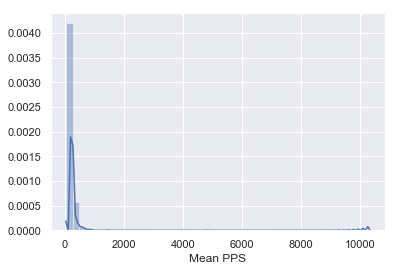

In [154]:
df2=df2[df2['Multiple Parcels Involved in Sale'] != "yes"]
sns.distplot(df2['Mean PPS'].dropna())

In [155]:
#This is the cause of the high RMSE. Outliers need cleaning.
plt.figure(figsize=(8,8))
print(df2.nlargest(10,columns=['Mean PPS']))

       Half Bath Building Type  Rooms      Mean PPS  \
57524        1.0         CONDO    4.0  10328.817982   
57541        1.0         CONDO    4.0  10328.817982   
57549        1.0         CONDO    4.0  10328.817982   
57557        1.0         CONDO    4.0  10328.817982   
57558        1.0         CONDO    5.0  10328.817982   
57563        1.0         CONDO    4.0  10328.817982   
19202        0.0         CONDO    4.0   7142.002048   
19203        0.0         CONDO    4.0   7142.002048   
19209        0.0         CONDO    4.0   7142.002048   
19212        0.0         CONDO    4.0   7142.002048   

      Multiple Parcels Involved in Sale  Year Built  Story Height Improved  
57524                                No      2009.0                    2.0  
57541                                No      2009.0                    2.0  
57549                                No      2009.0                    2.0  
57557                                No      2010.0                    2.0  
57558    

<Figure size 576x576 with 0 Axes>